In [1]:
# =========================
# 1) Importaciones básicas
# =========================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Capa entrenable: polinomio grado 3
# Entradas:  (batch, 1)  x en float/numérico
# Salidas:   (batch, 1)  f(x)
# Parámetros entrenables: a0, a1, a2, a3
class CubicPoly(layers.Layer):
    """
    Capa Keras que representa f(x) = a0 + a1*x + a2*x^2 + a3*x^3
    donde los coeficientes a0, a1, a2, a3 son entrenables.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Vector de coeficientes
        # Inicializamos en cero
        self.coeffs = self.add_weight(
            name="coeffs",
            shape=(4,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        # Aseguramos tipo float32
        x = tf.cast(inputs, tf.float32)           # (batch, 1)

        # Construimos la base 1, x, x^2, x^3 de forma vectorizada
        x1 = x                                     # (batch, 1)
        x2 = x1 * x1                               # (batch, 1)
        x3 = x2 * x1                               # (batch, 1)
        basis = tf.concat([tf.ones_like(x1), x1, x2, x3], axis=-1)  # (batch, 4)

        # Producto interno con los coeficientes (batch,)
        y = tf.tensordot(basis, self.coeffs, axes=[[-1], [0]])

        # Devolvemos con eje canal unidimensional para consistencia: (batch, 1)
        return tf.expand_dims(y, axis=-1)

    def get_config(self):
        return super().get_config()

In [3]:
import numpy as np

np.random.seed(0)
# Muestras aleatorias en el intervalo [-1, 1]
N = 2048
x_train = np.random.uniform(-1.0, 1.0, size=(N, 1)).astype(np.float32)
y_train = np.cos(2.0 * x_train).astype(np.float32)

# Rejilla densa para evaluación/validación
x_val = np.linspace(-1.0, 1.0, num=400, dtype=np.float32).reshape(-1, 1)
y_val = np.cos(2.0 * x_val).astype(np.float32)

In [4]:
inputs = keras.Input(shape=(1,), dtype=tf.float32)
poly = CubicPoly(name="poly")              # capa entrenable con a0..a3
outputs = poly(inputs)
model = keras.Model(inputs, outputs, name="cubic_poly")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.05),
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "cubic_poly"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ poly (CubicPoly)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4 (16.00 B)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=500,
    batch_size=128,
    verbose=0 
)

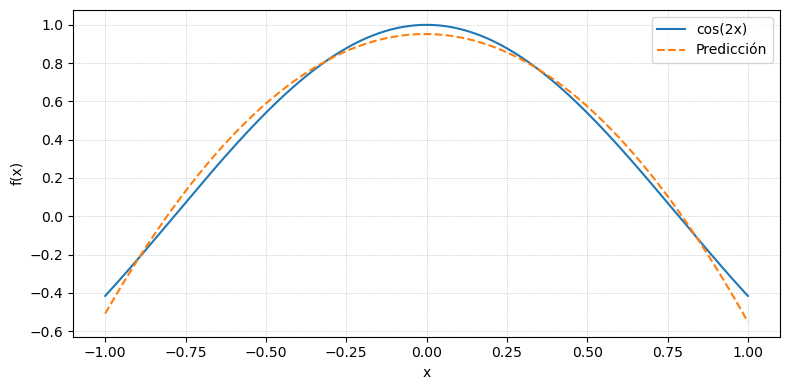

In [7]:
import matplotlib.pyplot as plt
# Predicción del modelo
y_pred = model.predict(x_val, batch_size=256, verbose=0)
plt.figure(figsize=(8, 4))
plt.plot(x_val.squeeze(), y_val.squeeze(), label="cos(2x)")
plt.plot(x_val.squeeze(), y_pred.squeeze(), linestyle="--", label="Predicción")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()

In [9]:
coeffs = poly.coeffs.numpy()  # [a0, a1, a2, a3]
print("Coeficientes (a0, a1, a2, a3):", coeffs)
a0, a1, a2, a3 = coeffs
print(f"Polinomio final: f(x) ≈ {a0:+.6f} {a1:+.6f}·x {a2:+.6f}·x² {a3:+.6f}·x³")

Coeficientes (a0, a1, a2, a3): [ 0.95200104 -0.01178385 -1.4820614  -0.00988126]
Polinomio final: f(x) ≈ +0.952001 -0.011784·x -1.482061·x² -0.009881·x³
